# Feature Creation Using Yelp and Zillow Data Set

## Machine Learning Problem

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import sqlite3
import dateutil.parser as parser
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

## Yelp Data Set extraction: Businesses by ZipCode

In [85]:
#Create Database Connection
DBName = 'yelp_project.db'
conn=sqlite3.connect(DBName)
cursor = conn.cursor()

In [87]:
#Read Business Data and query data from reviews
query = "SELECT b.business_id, categories, r.stars, attributes, date, useful, cool, funny, postal_code FROM review r JOIN \
business b USING (business_id) WHERE CAST(postal_code AS int)>=85000 AND CAST(postal_code AS int)<86400"
business_data = pd.read_sql_query(query,conn)
business_data.head()


,business_id,categories,stars,attributes,date,useful,cool,funny,postal_code
0,0DI8Dt2PJp07XkVvIElIcQ,"['Tobacco Shops', 'Nightlife', 'Vape Shops', '...",1,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-10-23,0,0,0,85283
1,0DI8Dt2PJp07XkVvIElIcQ,"['Tobacco Shops', 'Nightlife', 'Vape Shops', '...",4,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-05-17,0,0,0,85283
2,0DI8Dt2PJp07XkVvIElIcQ,"['Tobacco Shops', 'Nightlife', 'Vape Shops', '...",5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-10,0,0,0,85283
3,0DI8Dt2PJp07XkVvIElIcQ,"['Tobacco Shops', 'Nightlife', 'Vape Shops', '...",5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-16,0,0,0,85283
4,0DI8Dt2PJp07XkVvIElIcQ,"['Tobacco Shops', 'Nightlife', 'Vape Shops', '...",5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-07-15,0,0,0,85283


In [88]:
len(business_data)

1263470

In [90]:
## Split the column attributes one per row 
attributes_splitted = pd.concat([pd.Series(row['business_id'],row['categories'].split(',')) for _, row in business_data.dropna().iterrows()]).reset_index()
attributes_splitted.columns = ['categories', 'business_id']

In [210]:
attributes_splitted.head()

,categories,business_id,gen_cat
0,['Tobacco Shops',0DI8Dt2PJp07XkVvIElIcQ,not
1,'Nightlife',0DI8Dt2PJp07XkVvIElIcQ,not
2,'Vape Shops',0DI8Dt2PJp07XkVvIElIcQ,not
3,'Shopping'],0DI8Dt2PJp07XkVvIElIcQ,not
4,['Tobacco Shops',0DI8Dt2PJp07XkVvIElIcQ,not


In [220]:
import re
pattern = re.compile('([^\s\w]|_)+')
attributes_splitted['categories'] = attributes_splitted['categories'].apply(lambda x: pattern.sub('',x).lstrip())

In [228]:
cat_dic = pd.read_csv('Categories.csv')
cat_dic.columns = ['cat','new_cat']
cat_dic['cat'] = cat_dic['cat'].apply(lambda x: pattern.sub('',x).lstrip())
cat_dic = dict(zip(cat_dic.cat, cat_dic.new_cat))

In [230]:
attributes_splitted['gen_cat'] = attributes_splitted['categories'].apply(lambda x: cat_dic[x] if x in cat_dic.keys() else 'not')

In [232]:
attributes_splitted[attributes_splitted['gen_cat'] == 'not']

,categories,business_id,gen_cat


In [6]:
#Get Restaurants with price
restprice = attributes_splitted[attributes_splitted.Attributes.str.contains("restaurantspricerange", case=False)].reset_index()
restprice.head()

,index,Attributes,business_id
0,9,'RestaurantsPriceRange2: 2',0DI8Dt2PJp07XkVvIElIcQ
1,20,'RestaurantsPriceRange2: 2',0DI8Dt2PJp07XkVvIElIcQ
2,31,'RestaurantsPriceRange2: 2',0DI8Dt2PJp07XkVvIElIcQ
3,42,'RestaurantsPriceRange2: 2',0DI8Dt2PJp07XkVvIElIcQ
4,53,'RestaurantsPriceRange2: 2',0DI8Dt2PJp07XkVvIElIcQ


In [7]:
#Extract price range and remove non-numerical characters
restprice['Price'] = [ pd.to_numeric(re.sub(r"[\[\]' ]", "", r.split(":")[1])) for r in restprice.Attributes]
len(restprice)

986981

In [8]:
#keep business id and price column
business_price = restprice[['business_id', 'Price']]


In [9]:
#Left Join of both business data and business price data frame
business_data_Price = business_data.join(business_price, how = 'left', rsuffix='_bp')
business_data_Price.head()

,business_id,stars,attributes,date,useful,cool,funny,postal_code,business_id_bp,Price
0,0DI8Dt2PJp07XkVvIElIcQ,1,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-10-23,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0
1,0DI8Dt2PJp07XkVvIElIcQ,4,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-05-17,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0
2,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-10,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0
3,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-16,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0
4,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-07-15,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0


In [10]:
#Extract year from the date column
years=[pd.to_datetime(row['date']).year for _, row in business_data_Price.iterrows()]

In [11]:
#Veify Length of years
len(years)

1263470

In [12]:
#include year column in the complete dataframe
business_data_Price['Years'] = years
business_data_Price

,business_id,stars,attributes,date,useful,cool,funny,postal_code,business_id_bp,Price,Years
0,0DI8Dt2PJp07XkVvIElIcQ,1,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-10-23,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
1,0DI8Dt2PJp07XkVvIElIcQ,4,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-05-17,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
2,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-10,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
3,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-06-16,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
4,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-07-15,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
5,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-08-16,1,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
6,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-08-31,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
7,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-10-04,1,1,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
8,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-12-29,0,0,0,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014
9,0DI8Dt2PJp07XkVvIElIcQ,5,"['BikeParking: True', 'BusinessAcceptsBitcoin:...",2014-03-11,0,0,1,85283,0DI8Dt2PJp07XkVvIElIcQ,2.0,2014


In [13]:
#create dummy variables for the number of the stars

zip_matrix = business_data_Price[['postal_code', 'Years', 'stars', 'useful', 'funny', 'cool', 'Price']]
stars = zip_matrix.stars
zip_matrix = pd.get_dummies(zip_matrix, columns = ["stars"])
zip_matrix['stars'] = stars
zip_matrix.head()

,postal_code,Years,useful,funny,cool,Price,stars_1,stars_2,stars_3,stars_4,stars_5,stars
0,85283,2014,0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1
1,85283,2014,0,0,0,2.0,0.0,0.0,0.0,1.0,0.0,4
2,85283,2014,0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,5
3,85283,2014,0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,5
4,85283,2014,0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,5


Now, we want to aggregate by zipcode and obtain features that describe the distribution

## Obtain mean, median and standard deviation of every measure

In [14]:
#aggregate the data by ZIPCODE, calculating the means of each feature
zip_aggregated = zip_matrix.groupby(['postal_code', 'Years']).agg([np.mean, np.std, np.median])
zip_aggregated.head()

useful                      funny                   \
                       mean       std median      mean       std median   
postal_code Years                                                         
85000       2011   2.833333  2.136976    3.0  1.000000  1.095445    1.0   
            2012   1.076923  2.253203    0.0  0.230769  0.832050    0.0   
            2013   3.000000  3.464102    3.0  1.000000  1.414214    0.5   
            2014   0.250000  0.500000    0.0  0.000000  0.000000    0.0   
            2015   0.250000  0.500000    0.0  0.000000  0.000000    0.0   

                       cool                  Price  ...   stars_3 stars_4  \
                       mean       std median  mean  ...    median    mean   
postal_code Years                                   ...                     
85000       2011   0.500000  0.836660    0.0   2.0  ...       0.0     0.0   
            2012   0.461538  0.877058    0.0   2.0  ...       0.0     0.0   
            2013   1.750000  2.872281    0.5   2.0  ...       0.0     0.0   
            2014   0.000000  0.000000    0.0   2.0  ...       0.0     0.0   
            2015   0.000000  0.000000    0.0   2.0  ...       0.0     0.0   

                                stars_5                     stars           \
                   std median      mean      std median      mean      std   
postal_code Years                                                            
85000       2011   0.0    0.0  1.000000  0.00000    1.0  5.000000  0.00000   
            2012   0.0    0.0  0.923077  0.27735    1.0  4.769231  0.83205   
            2013   0.0    0.0  0.750000  0.50000    1.0  4.000000  2.00000   
            2014   0.0    0.0  1.000000  0.00000    1.0  5.000000  0.00000   
            2015   0.0    0.0  1.000000  0.00000    1.0  5.000000  0.00000   

                          
                  median  
postal_code Years         
85000       2011     5.0  
            2012     5.0  
            2013     5.0  
            2014     5.0  
            2015     5.0  

[5 rows x 30 columns]

In [15]:
# change column names to eliminate nested columns
zip_aggregated.columns = ['_'.join(col).strip() for col in zip_aggregated.columns.values]
zip_aggregated.head()

useful_mean  useful_std  useful_median  funny_mean  \
postal_code Years                                                       
85000       2011      2.833333    2.136976            3.0    1.000000   
            2012      1.076923    2.253203            0.0    0.230769   
            2013      3.000000    3.464102            3.0    1.000000   
            2014      0.250000    0.500000            0.0    0.000000   
            2015      0.250000    0.500000            0.0    0.000000   

                   funny_std  funny_median  cool_mean  cool_std  cool_median  \
postal_code Years                                                              
85000       2011    1.095445           1.0   0.500000  0.836660          0.0   
            2012    0.832050           0.0   0.461538  0.877058          0.0   
            2013    1.414214           0.5   1.750000  2.872281          0.5   
            2014    0.000000           0.0   0.000000  0.000000          0.0   
            2015    0.000000           0.0   0.000000  0.000000          0.0   

                   Price_mean      ...       stars_3_median  stars_4_mean  \
postal_code Years                  ...                                      
85000       2011          2.0      ...                  0.0           0.0   
            2012          2.0      ...                  0.0           0.0   
            2013          2.0      ...                  0.0           0.0   
            2014          2.0      ...                  0.0           0.0   
            2015          2.0      ...                  0.0           0.0   

                   stars_4_std  stars_4_median  stars_5_mean  stars_5_std  \
postal_code Years                                                           
85000       2011           0.0             0.0      1.000000      0.00000   
            2012           0.0             0.0      0.923077      0.27735   
            2013           0.0             0.0      0.750000      0.50000   
            2014           0.0             0.0      1.000000      0.00000   
            2015           0.0             0.0      1.000000      0.00000   

                   stars_5_median  stars_mean  stars_std  stars_median  
postal_code Years                                                       
85000       2011              1.0    5.000000    0.00000           5.0  
            2012              1.0    4.769231    0.83205           5.0  
            2013              1.0    4.000000    2.00000           5.0  
            2014              1.0    5.000000    0.00000           5.0  
            2015              1.0    5.000000    0.00000           5.0  

[5 rows x 30 columns]

In [16]:
#drop duplicates to have just one single price per business for each zipcode (the number of reviews do not matter)

business_price_zip = business_data_Price[['business_id','Price', 'postal_code', 'Years']].drop_duplicates()
price_zip = business_price_zip[['postal_code', 'Price', 'Years']]
price_zip.head()

,postal_code,Price,Years
0,85283,2.0,2014
17,85259,2.0,2012
18,85259,2.0,2015
19,85259,2.0,2013
21,85259,2.0,2014


In [17]:
#calculate the price
average_price_zip = price_zip.groupby(['postal_code','Years']).agg([np.mean, np.std, np.median, np.count_nonzero])
average_price_zip.columns = ['_'.join(col).strip() for col in average_price_zip.columns.values]
average_price_zip.head()

Price_mean  Price_std  Price_median  Price_count_nonzero
postal_code Years                                                          
85000       2011          2.0        NaN           2.0                  1.0
            2012          2.0        NaN           2.0                  1.0
            2013          2.0        NaN           2.0                  1.0
            2014          2.0        NaN           2.0                  1.0
            2015          2.0        NaN           2.0                  1.0

In [18]:
#include the price column in the aggregated dataframe
zip_aggregated['Price_mean'] = average_price_zip['Price_mean']
zip_aggregated['Price_median'] = average_price_zip['Price_median']
zip_aggregated['Price_std'] = average_price_zip['Price_std']
zip_aggregated['No_business'] = average_price_zip['Price_count_nonzero']
zip_aggregated.reset_index()[zip_aggregated.reset_index()['postal_code'] == '85003']

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_4_mean,stars_4_std,stars_4_median,stars_5_mean,stars_5_std,stars_5_median,stars_mean,stars_std,stars_median,No_business
23,85003,2006,1.681818,1.672932,1.0,1.045455,1.646852,0.5,1.409091,1.402688,...,0.318182,0.476731,0.0,0.227273,0.428932,0.0,3.500000,1.224745,4.0,15.0
24,85003,2007,2.945312,3.100187,2.0,1.843750,2.879298,1.0,2.656250,2.600537,...,0.304688,0.462084,0.0,0.351562,0.479334,0.0,3.781250,1.190100,4.0,44.0
25,85003,2008,3.200000,3.292023,2.0,2.237778,3.904072,1.0,2.635556,2.930612,...,0.311111,0.463463,0.0,0.297778,0.457790,0.0,3.633333,1.240106,4.0,72.0
26,85003,2009,2.694719,3.531329,2.0,1.735974,3.415994,1.0,2.150165,3.492929,...,0.359736,0.480319,0.0,0.295380,0.456590,0.0,3.716172,1.188917,4.0,81.0
27,85003,2010,1.560914,2.554632,1.0,0.784264,2.079526,0.0,0.977157,2.121347,...,0.371827,0.483600,0.0,0.348985,0.476952,0.0,3.884518,1.134249,4.0,103.0
28,85003,2011,1.506351,2.118763,1.0,0.625741,1.517853,0.0,0.766300,1.520899,...,0.325995,0.468944,0.0,0.355631,0.478907,0.0,3.770533,1.261830,4.0,140.0
29,85003,2012,1.340246,1.907200,1.0,0.582181,1.505998,0.0,0.653610,1.335605,...,0.288786,0.453373,0.0,0.394009,0.488825,0.0,3.792627,1.310986,4.0,166.0
30,85003,2013,1.222102,2.215043,0.0,0.497574,1.344961,0.0,0.619407,1.497085,...,0.279245,0.448749,0.0,0.401078,0.490249,0.0,3.780593,1.335698,4.0,212.0
31,85003,2014,0.983722,1.857356,0.0,0.381428,1.086855,0.0,0.429893,1.107218,...,0.248983,0.432504,0.0,0.475398,0.499487,0.0,3.906030,1.358981,4.0,238.0
32,85003,2015,0.953163,2.059415,0.0,0.362835,1.235089,0.0,0.465937,1.466198,...,0.222324,0.415871,0.0,0.511861,0.499935,1.0,3.953771,1.372618,5.0,266.0


In [19]:
zip_aggregated.columns

Index(['useful_mean', 'useful_std', 'useful_median', 'funny_mean', 'funny_std',
       'funny_median', 'cool_mean', 'cool_std', 'cool_median', 'Price_mean',
       'Price_std', 'Price_median', 'stars_1_mean', 'stars_1_std',
       'stars_1_median', 'stars_2_mean', 'stars_2_std', 'stars_2_median',
       'stars_3_mean', 'stars_3_std', 'stars_3_median', 'stars_4_mean',
       'stars_4_std', 'stars_4_median', 'stars_5_mean', 'stars_5_std',
       'stars_5_median', 'stars_mean', 'stars_std', 'stars_median',
       'No_business'],
      dtype='object')

## Proportion of reviews per year

Now, we want to calculate the proportion of revies corresponding to each zipcode, from all the reviews in a given year

In [20]:
#Calculations to use in computing the proportion of reviews

average_reviews_zip = business_data_Price.groupby(['postal_code','Years']).agg(pd.Series.count)
average_reviews_zip = average_reviews_zip['business_id']
review_byzip = business_data_Price.groupby(['postal_code', 'Years']).count()
total_reviews = business_data_Price.groupby(['Years']).count().business_id
review_byzip = review_byzip.reset_index()[['postal_code','Years','business_id']]


In [21]:
#calculate the proportion of reviews that each zipcode has for each year
prop_reviews = [ float(review_byzip.ix[i]['business_id'])/total_reviews[review_byzip.ix[i]['Years']] for i in range(len(review_byzip))]

In [22]:
#include in aggreged data set
zip_aggregated['reviews_perc'] = prop_reviews
zip_aggregated.head()

useful_mean  useful_std  useful_median  funny_mean  \
postal_code Years                                                       
85000       2011      2.833333    2.136976            3.0    1.000000   
            2012      1.076923    2.253203            0.0    0.230769   
            2013      3.000000    3.464102            3.0    1.000000   
            2014      0.250000    0.500000            0.0    0.000000   
            2015      0.250000    0.500000            0.0    0.000000   

                   funny_std  funny_median  cool_mean  cool_std  cool_median  \
postal_code Years                                                              
85000       2011    1.095445           1.0   0.500000  0.836660          0.0   
            2012    0.832050           0.0   0.461538  0.877058          0.0   
            2013    1.414214           0.5   1.750000  2.872281          0.5   
            2014    0.000000           0.0   0.000000  0.000000          0.0   
            2015    0.000000           0.0   0.000000  0.000000          0.0   

                   Price_mean      ...       stars_4_std  stars_4_median  \
postal_code Years                  ...                                     
85000       2011          2.0      ...               0.0             0.0   
            2012          2.0      ...               0.0             0.0   
            2013          2.0      ...               0.0             0.0   
            2014          2.0      ...               0.0             0.0   
            2015          2.0      ...               0.0             0.0   

                   stars_5_mean  stars_5_std  stars_5_median  stars_mean  \
postal_code Years                                                          
85000       2011       1.000000      0.00000             1.0    5.000000   
            2012       0.923077      0.27735             1.0    4.769231   
            2013       0.750000      0.50000             1.0    4.000000   
            2014       1.000000      0.00000             1.0    5.000000   
            2015       1.000000      0.00000             1.0    5.000000   

                   stars_std  stars_median  No_business  reviews_perc  
postal_code Years                                                      
85000       2011     0.00000           5.0          1.0      0.000071  
            2012     0.83205           5.0          1.0      0.000134  
            2013     2.00000           5.0          1.0      0.000028  
            2014     0.00000           5.0          1.0      0.000019  
            2015     0.00000           5.0          1.0      0.000014  

[5 rows x 32 columns]

In [23]:
zip_aggregated.columns

Index(['useful_mean', 'useful_std', 'useful_median', 'funny_mean', 'funny_std',
       'funny_median', 'cool_mean', 'cool_std', 'cool_median', 'Price_mean',
       'Price_std', 'Price_median', 'stars_1_mean', 'stars_1_std',
       'stars_1_median', 'stars_2_mean', 'stars_2_std', 'stars_2_median',
       'stars_3_mean', 'stars_3_std', 'stars_3_median', 'stars_4_mean',
       'stars_4_std', 'stars_4_median', 'stars_5_mean', 'stars_5_std',
       'stars_5_median', 'stars_mean', 'stars_std', 'stars_median',
       'No_business', 'reviews_perc'],
      dtype='object')

Include changes for each column

In [24]:
flatten_zip = zip_aggregated.reset_index()
for col in flatten_zip.columns[2:]:
    col_name = col + '_change'
    flatten_zip[col_name] = np.where((flatten_zip['postal_code']==flatten_zip['postal_code'].shift())  & \
                                     (flatten_zip['Years'].shift() == (flatten_zip['Years']-1)),\
                                     (flatten_zip[col]-flatten_zip[col].shift())/flatten_zip[col].shift(),0)
    #df['u'] = np.where(df['Set']=='Z', 'green', 'red')



In [25]:
flatten_zip.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_4_std_change,stars_4_median_change,stars_5_mean_change,stars_5_std_change,stars_5_median_change,stars_mean_change,stars_std_change,stars_median_change,No_business_change,reviews_perc_change
0,85000,2011,2.833333,2.136976,3.0,1.000000,1.095445,1.0,0.500000,0.836660,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,85000,2012,1.076923,2.253203,0.0,0.230769,0.832050,0.0,0.461538,0.877058,...,NaN,NaN,-0.076923,inf,0.0,-0.046154,inf,0.0,0.0,0.869411
2,85000,2013,3.000000,3.464102,3.0,1.000000,1.414214,0.5,1.750000,2.872281,...,NaN,NaN,-0.187500,0.802776,0.0,-0.161290,1.403701,0.0,0.0,-0.788608
3,85000,2014,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,0.333333,-1.000000,0.0,0.250000,-1.000000,0.0,0.0,-0.317504
4,85000,2015,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,0.000000,NaN,0.0,0.000000,NaN,0.0,0.0,-0.248003


In [26]:
flatten_zip.columns

Index(['postal_code', 'Years', 'useful_mean', 'useful_std', 'useful_median',
       'funny_mean', 'funny_std', 'funny_median', 'cool_mean', 'cool_std',
       'cool_median', 'Price_mean', 'Price_std', 'Price_median',
       'stars_1_mean', 'stars_1_std', 'stars_1_median', 'stars_2_mean',
       'stars_2_std', 'stars_2_median', 'stars_3_mean', 'stars_3_std',
       'stars_3_median', 'stars_4_mean', 'stars_4_std', 'stars_4_median',
       'stars_5_mean', 'stars_5_std', 'stars_5_median', 'stars_mean',
       'stars_std', 'stars_median', 'No_business', 'reviews_perc',
       'useful_mean_change', 'useful_std_change', 'useful_median_change',
       'funny_mean_change', 'funny_std_change', 'funny_median_change',
       'cool_mean_change', 'cool_std_change', 'cool_median_change',
       'Price_mean_change', 'Price_std_change', 'Price_median_change',
       'stars_1_mean_change', 'stars_1_std_change', 'stars_1_median_change',
       'stars_2_mean_change', 'stars_2_std_change', 'stars_2_median_

In [27]:
#calculate the previous mean stars that the zipcode received in the previous year
avg_review_prev1 = [flatten_zip[(flatten_zip['postal_code']==flatten_zip.ix[i]['postal_code'])&(flatten_zip['Years']==(flatten_zip.ix[i]['Years']-1))]['stars_mean'].values for i in range(len(flatten_zip))]

In [28]:
#include the previous star mean in the aggregated data frame
zip_aggregated_2 = flatten_zip
zip_aggregated_2['prev_stars'] = avg_review_prev1
zip_aggregated_2['prev_stars'] = zip_aggregated_2['prev_stars'].str.get(0)
zip_aggregated_2.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_4_median_change,stars_5_mean_change,stars_5_std_change,stars_5_median_change,stars_mean_change,stars_std_change,stars_median_change,No_business_change,reviews_perc_change,prev_stars
0,85000,2011,2.833333,2.136976,3.0,1.000000,1.095445,1.0,0.500000,0.836660,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,NaN
1,85000,2012,1.076923,2.253203,0.0,0.230769,0.832050,0.0,0.461538,0.877058,...,NaN,-0.076923,inf,0.0,-0.046154,inf,0.0,0.0,0.869411,5.000000
2,85000,2013,3.000000,3.464102,3.0,1.000000,1.414214,0.5,1.750000,2.872281,...,NaN,-0.187500,0.802776,0.0,-0.161290,1.403701,0.0,0.0,-0.788608,4.769231
3,85000,2014,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,0.333333,-1.000000,0.0,0.250000,-1.000000,0.0,0.0,-0.317504,4.000000
4,85000,2015,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,0.000000,NaN,0.0,0.000000,NaN,0.0,0.0,-0.248003,5.000000


In [29]:
zip_aggregated_2.columns

Index(['postal_code', 'Years', 'useful_mean', 'useful_std', 'useful_median',
       'funny_mean', 'funny_std', 'funny_median', 'cool_mean', 'cool_std',
       'cool_median', 'Price_mean', 'Price_std', 'Price_median',
       'stars_1_mean', 'stars_1_std', 'stars_1_median', 'stars_2_mean',
       'stars_2_std', 'stars_2_median', 'stars_3_mean', 'stars_3_std',
       'stars_3_median', 'stars_4_mean', 'stars_4_std', 'stars_4_median',
       'stars_5_mean', 'stars_5_std', 'stars_5_median', 'stars_mean',
       'stars_std', 'stars_median', 'No_business', 'reviews_perc',
       'useful_mean_change', 'useful_std_change', 'useful_median_change',
       'funny_mean_change', 'funny_std_change', 'funny_median_change',
       'cool_mean_change', 'cool_std_change', 'cool_median_change',
       'Price_mean_change', 'Price_std_change', 'Price_median_change',
       'stars_1_mean_change', 'stars_1_std_change', 'stars_1_median_change',
       'stars_2_mean_change', 'stars_2_std_change', 'stars_2_median_

In [30]:
#save to pickle ------- Checkpoint
import pickle
output_file = open("Feature_Matrix_onlyYelp.dat","wb")
pickle.dump(zip_aggregated, output_file)
output_file.close()

## Zillow Data Set Extraction and Integration: Median price per square foot


In [31]:
#Integrate Zillow
zip_price = pd.read_csv("Zip_MedianValuePerSqft_AllHomes.csv")

#Select only the zipcodes needed
city_data_price = zip_price[(zip_price.RegionName>=85000)&(zip_price.RegionName<86400)]

#Select the RegionName and the columns with year
city_data_byYear = pd.concat([city_data_price.ix[:,1], city_data_price[city_data_price.columns[7:]]], axis = 1)

#Melt the dataframe to transform the columns into rows
flat_zip = pd.melt(city_data_byYear, id_vars="RegionName", var_name="Date", value_name="MedSqft")
flat_zip.head()

,RegionName,Date,MedSqft
0,85032,1996-04,65.0
1,85710,1996-04,60.0
2,85225,1996-04,63.0
3,85308,1996-04,65.0
4,85281,1996-04,63.0


In [32]:
#Extract only the years
years = [flat_zip.Date.ix[i].split('-')[0] for i in range(len(flat_zip))]

#Add to df
flat_zip['Years'] = years

#Select only these columns
flat_zip = flat_zip[['RegionName', 'Years', 'MedSqft']]

#Group by and aggregate by median
med_zip = flat_zip.groupby(['RegionName', 'Years']).median()

#Flatten the table
med_zip = med_zip.reset_index()
med_zip.head()

,RegionName,Years,MedSqft
0,85003,1996,84.0
1,85003,1997,87.0
2,85003,1998,99.5
3,85003,1999,106.5
4,85003,2000,116.0


In [33]:
#match the zip codes in zillow with the zipcodes in YELP by year and obtain the corresponding median price per sqft
Med_price_sqft = [med_zip[(med_zip['RegionName']==int(zip_aggregated_2.ix[i]['postal_code']))&(med_zip['Years']==str(zip_aggregated_2.ix[i]['Years']))]['MedSqft'].values for i in range(len(zip_aggregated_2))]

In [34]:
#include the median price per squarefeet in the aggregated data set
zip_aggregated_2['MedPrice_sqft'] = Med_price_sqft
zip_aggregated_2['MedPrice_sqft'] = zip_aggregated_2['MedPrice_sqft'].str.get(0)
zip_aggregated_2.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_5_mean_change,stars_5_std_change,stars_5_median_change,stars_mean_change,stars_std_change,stars_median_change,No_business_change,reviews_perc_change,prev_stars,MedPrice_sqft
0,85000,2011,2.833333,2.136976,3.0,1.000000,1.095445,1.0,0.500000,0.836660,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN
1,85000,2012,1.076923,2.253203,0.0,0.230769,0.832050,0.0,0.461538,0.877058,...,-0.076923,inf,0.0,-0.046154,inf,0.0,0.0,0.869411,5.000000,NaN
2,85000,2013,3.000000,3.464102,3.0,1.000000,1.414214,0.5,1.750000,2.872281,...,-0.187500,0.802776,0.0,-0.161290,1.403701,0.0,0.0,-0.788608,4.769231,NaN
3,85000,2014,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.333333,-1.000000,0.0,0.250000,-1.000000,0.0,0.0,-0.317504,4.000000,NaN
4,85000,2015,0.250000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,NaN,0.0,0.000000,NaN,0.0,0.0,-0.248003,5.000000,NaN


In [35]:
#drop NaN values in the med_price_sqft
zip_aggregated_2 = zip_aggregated_2.dropna(subset=['MedPrice_sqft'])
zip_aggregated_2 = zip_aggregated_2.reset_index(drop=True)
zip_aggregated_2.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_5_mean_change,stars_5_std_change,stars_5_median_change,stars_mean_change,stars_std_change,stars_median_change,No_business_change,reviews_perc_change,prev_stars,MedPrice_sqft
0,85003,2006,1.681818,1.672932,1.0,1.045455,1.646852,0.5,1.409091,1.402688,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,253.0
1,85003,2007,2.945312,3.100187,2.0,1.843750,2.879298,1.0,2.656250,2.600537,...,0.546875,0.117506,NaN,0.080357,-0.028287,0.0,1.933333,0.053949,3.500000,256.5
2,85003,2008,3.200000,3.292023,2.0,2.237778,3.904072,1.0,2.635556,2.930612,...,-0.152988,-0.044946,NaN,-0.039118,0.042018,0.0,0.636364,0.344674,3.781250,221.5
3,85003,2009,2.694719,3.531329,2.0,1.735974,3.415994,1.0,2.150165,3.492929,...,-0.008054,-0.002622,NaN,0.022800,-0.041278,0.0,0.125000,-0.199636,3.633333,196.0
4,85003,2010,1.560914,2.554632,1.0,0.784264,2.079526,0.0,0.977157,2.121347,...,0.181479,0.044595,NaN,0.045301,-0.045982,0.0,0.271605,-0.216791,3.716172,153.5


Now, we wish to include the past median price per square foot (from the zillow data)

In [36]:
#For t=t-1
t=-1
Med_price_sqft_tminus1 = [med_zip[(med_zip['RegionName']==int(zip_aggregated_2.ix[i]['postal_code']))&(med_zip['Years']==str(zip_aggregated_2.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(zip_aggregated_2))]

In [37]:
#For t=t-2
t=-2
Med_price_sqft_tminus2 = [med_zip[(med_zip['RegionName']==int(zip_aggregated_2.ix[i]['postal_code']))&(med_zip['Years']==str(zip_aggregated_2.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(zip_aggregated_2))]

In [38]:
#For t=t+1
t=1
Med_price_sqft_tplus1 = [med_zip[(med_zip['RegionName']==int(zip_aggregated_2.ix[i]['postal_code']))&(med_zip['Years']==str(zip_aggregated_2.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(zip_aggregated_2))]

In [39]:
#Include the previous and T+1 price per square foot in the aggregated data set

zip_aggregated_2['MedPrice_sqft_tminus1'] = Med_price_sqft_tminus1
zip_aggregated_2['MedPrice_sqft_tminus1'] = zip_aggregated_2['MedPrice_sqft_tminus1'].str.get(0)

zip_aggregated_2['MedPrice_sqft_tminus2'] = Med_price_sqft_tminus2
zip_aggregated_2['MedPrice_sqft_tminus2'] = zip_aggregated_2['MedPrice_sqft_tminus2'].str.get(0)

zip_aggregated_2['MedPrice_sqft_tplus1'] = Med_price_sqft_tplus1
zip_aggregated_2['MedPrice_sqft_tplus1'] = zip_aggregated_2['MedPrice_sqft_tplus1'].str.get(0)

#zip_aggregated.head()

In [40]:
zip_aggregated_2.columns

Index(['postal_code', 'Years', 'useful_mean', 'useful_std', 'useful_median',
       'funny_mean', 'funny_std', 'funny_median', 'cool_mean', 'cool_std',
       'cool_median', 'Price_mean', 'Price_std', 'Price_median',
       'stars_1_mean', 'stars_1_std', 'stars_1_median', 'stars_2_mean',
       'stars_2_std', 'stars_2_median', 'stars_3_mean', 'stars_3_std',
       'stars_3_median', 'stars_4_mean', 'stars_4_std', 'stars_4_median',
       'stars_5_mean', 'stars_5_std', 'stars_5_median', 'stars_mean',
       'stars_std', 'stars_median', 'No_business', 'reviews_perc',
       'useful_mean_change', 'useful_std_change', 'useful_median_change',
       'funny_mean_change', 'funny_std_change', 'funny_median_change',
       'cool_mean_change', 'cool_std_change', 'cool_median_change',
       'Price_mean_change', 'Price_std_change', 'Price_median_change',
       'stars_1_mean_change', 'stars_1_std_change', 'stars_1_median_change',
       'stars_2_mean_change', 'stars_2_std_change', 'stars_2_median_

In [41]:
#Checkpoint----------------- export data

output_file = open("Feature_Matrix_complete.dat","wb")
pickle.dump(zip_aggregated, output_file)
output_file.close()

#export to CSV
zip_aggregated.to_csv("Feature_Matrix_Yelp_Complete.csv")

In [42]:
#Import data set

input_file = open("Feature_Matrix_complete.dat","rb")
zip_aggregated = pickle.load(input_file)
input_file.close()
zip_aggregated.head()

useful_mean  useful_std  useful_median  funny_mean  \
postal_code Years                                                       
85000       2011      2.833333    2.136976            3.0    1.000000   
            2012      1.076923    2.253203            0.0    0.230769   
            2013      3.000000    3.464102            3.0    1.000000   
            2014      0.250000    0.500000            0.0    0.000000   
            2015      0.250000    0.500000            0.0    0.000000   

                   funny_std  funny_median  cool_mean  cool_std  cool_median  \
postal_code Years                                                              
85000       2011    1.095445           1.0   0.500000  0.836660          0.0   
            2012    0.832050           0.0   0.461538  0.877058          0.0   
            2013    1.414214           0.5   1.750000  2.872281          0.5   
            2014    0.000000           0.0   0.000000  0.000000          0.0   
            2015    0.000000           0.0   0.000000  0.000000          0.0   

                   Price_mean      ...       stars_4_std  stars_4_median  \
postal_code Years                  ...                                     
85000       2011          2.0      ...               0.0             0.0   
            2012          2.0      ...               0.0             0.0   
            2013          2.0      ...               0.0             0.0   
            2014          2.0      ...               0.0             0.0   
            2015          2.0      ...               0.0             0.0   

                   stars_5_mean  stars_5_std  stars_5_median  stars_mean  \
postal_code Years                                                          
85000       2011       1.000000      0.00000             1.0    5.000000   
            2012       0.923077      0.27735             1.0    4.769231   
            2013       0.750000      0.50000             1.0    4.000000   
            2014       1.000000      0.00000             1.0    5.000000   
            2015       1.000000      0.00000             1.0    5.000000   

                   stars_std  stars_median  No_business  reviews_perc  
postal_code Years                                                      
85000       2011     0.00000           5.0          1.0      0.000071  
            2012     0.83205           5.0          1.0      0.000134  
            2013     2.00000           5.0          1.0      0.000028  
            2014     0.00000           5.0          1.0      0.000019  
            2015     0.00000           5.0          1.0      0.000014  

[5 rows x 32 columns]

## Include area and business density

In [43]:
#Read data from the zip codes
area_data = pd.read_excel("zcta2010.xls")

In [44]:
#select the zipcodes of interest
area_data = area_data[(area_data['ZCTA5'] >= 85000) & (area_data['ZCTA5'] <= 86400)]
area_data.head()

,ZCTA5,LANDSQMT,WATERSQMT,LANDSQMI,WATERSQMI,POPULATION,HSGUNITS,INTPTLAT,INTPTLON
29062,85003,4795027,0,1.851370,0.000000,9369,4910,33.450662,-112.078353
29063,85004,5283332,0,2.039906,0.000000,4965,2804,33.451567,-112.069886
29064,85006,10108876,2685,3.903059,0.001037,25742,10183,33.465234,-112.048771
29065,85007,11690704,182632,4.513806,0.070515,14040,5916,33.447614,-112.090883
29066,85008,27110870,142271,10.467566,0.054931,56145,23282,33.462954,-111.985178


In [45]:
#match the zip codes in area data frame with the zipcodes in YELP by year and obtain the corresponding median price per sqft
Area = [area_data[(area_data['ZCTA5']==int(zip_aggregated_2.ix[i]['postal_code']))]['LANDSQMI'].values for i in range(len(zip_aggregated_2))]

In [46]:
#include area information in the aggregated data set
zip_aggregated_3 = zip_aggregated_2
zip_aggregated_3['Area'] = Area
zip_aggregated_3['Area'] = zip_aggregated_3['Area'].str.get(0)
zip_aggregated_3.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,stars_std_change,stars_median_change,No_business_change,reviews_perc_change,prev_stars,MedPrice_sqft,MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Area
0,85003,2006,1.681818,1.672932,1.0,1.045455,1.646852,0.5,1.409091,1.402688,...,0.000000,0.0,0.000000,0.000000,NaN,253.0,215.5,156.5,256.5,1.85137
1,85003,2007,2.945312,3.100187,2.0,1.843750,2.879298,1.0,2.656250,2.600537,...,-0.028287,0.0,1.933333,0.053949,3.500000,256.5,253.0,215.5,221.5,1.85137
2,85003,2008,3.200000,3.292023,2.0,2.237778,3.904072,1.0,2.635556,2.930612,...,0.042018,0.0,0.636364,0.344674,3.781250,221.5,256.5,253.0,196.0,1.85137
3,85003,2009,2.694719,3.531329,2.0,1.735974,3.415994,1.0,2.150165,3.492929,...,-0.041278,0.0,0.125000,-0.199636,3.633333,196.0,221.5,256.5,153.5,1.85137
4,85003,2010,1.560914,2.554632,1.0,0.784264,2.079526,0.0,0.977157,2.121347,...,-0.045982,0.0,0.271605,-0.216791,3.716172,153.5,196.0,221.5,143.5,1.85137


In [47]:
zip_aggregated_3 = zip_aggregated_3.dropna(subset=['Area'])

In [48]:
zip_aggregated_3.columns

Index(['postal_code', 'Years', 'useful_mean', 'useful_std', 'useful_median',
       'funny_mean', 'funny_std', 'funny_median', 'cool_mean', 'cool_std',
       'cool_median', 'Price_mean', 'Price_std', 'Price_median',
       'stars_1_mean', 'stars_1_std', 'stars_1_median', 'stars_2_mean',
       'stars_2_std', 'stars_2_median', 'stars_3_mean', 'stars_3_std',
       'stars_3_median', 'stars_4_mean', 'stars_4_std', 'stars_4_median',
       'stars_5_mean', 'stars_5_std', 'stars_5_median', 'stars_mean',
       'stars_std', 'stars_median', 'No_business', 'reviews_perc',
       'useful_mean_change', 'useful_std_change', 'useful_median_change',
       'funny_mean_change', 'funny_std_change', 'funny_median_change',
       'cool_mean_change', 'cool_std_change', 'cool_median_change',
       'Price_mean_change', 'Price_std_change', 'Price_median_change',
       'stars_1_mean_change', 'stars_1_std_change', 'stars_1_median_change',
       'stars_2_mean_change', 'stars_2_std_change', 'stars_2_median_

## Include the Number of Business per sqft & change

In [49]:
zip_aggregated_3['NumBsqft_Rev'] = zip_aggregated_3['No_business']/zip_aggregated_3['Area']


C:\Users\jose oros\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [50]:
zip_aggregated_3['Bsqft_change'] = np.where((zip_aggregated_3['postal_code']==zip_aggregated_3['postal_code'].shift())  & \
                                     (zip_aggregated_3['Years'].shift() == (zip_aggregated_3['Years']-1)),\
                                     (zip_aggregated_3['NumBsqft_Rev']-zip_aggregated_3['NumBsqft_Rev'].shift())/zip_aggregated_3['NumBsqft_Rev'].shift(),0)

C:\Users\jose oros\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
zip_aggregated_3 = zip_aggregated_3.reset_index(drop=True)

Now, we will include the change in price from year to year for each zipcode

In [60]:
zip_aggregated_3.head()

,postal_code,Years,useful_mean,useful_std,useful_median,funny_mean,funny_std,funny_median,cool_mean,cool_std,...,No_business_change,reviews_perc_change,prev_stars,MedPrice_sqft,MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Area,NumBsqft_Rev,Bsqft_change
0,85003,2006,1.681818,1.672932,1.0,1.045455,1.646852,0.5,1.409091,1.402688,...,0.000000,0.000000,NaN,253.0,215.5,156.5,256.5,1.85137,8.102107,0.000000
1,85003,2007,2.945312,3.100187,2.0,1.843750,2.879298,1.0,2.656250,2.600537,...,1.933333,0.053949,3.500000,256.5,253.0,215.5,221.5,1.85137,23.766179,1.933333
2,85003,2008,3.200000,3.292023,2.0,2.237778,3.904072,1.0,2.635556,2.930612,...,0.636364,0.344674,3.781250,221.5,256.5,253.0,196.0,1.85137,38.890112,0.636364
3,85003,2009,2.694719,3.531329,2.0,1.735974,3.415994,1.0,2.150165,3.492929,...,0.125000,-0.199636,3.633333,196.0,221.5,256.5,153.5,1.85137,43.751376,0.125000
4,85003,2010,1.560914,2.554632,1.0,0.784264,2.079526,0.0,0.977157,2.121347,...,0.271605,-0.216791,3.716172,153.5,196.0,221.5,143.5,1.85137,55.634465,0.271605


In [67]:
#Growth change 

import math

t=-1
Growth_Y2Y = [((zip_aggregated_3.ix[i]['MedPrice_sqft_tplus1']-zip_aggregated_3.ix[i]['MedPrice_sqft'])/zip_aggregated_3.ix[i]['MedPrice_sqft']) for i in range(len(zip_aggregated_3))]

#include in aggregated data set
zip_aggregated_3['Y'] = Growth_Y2Y

C:\Users\jose oros\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


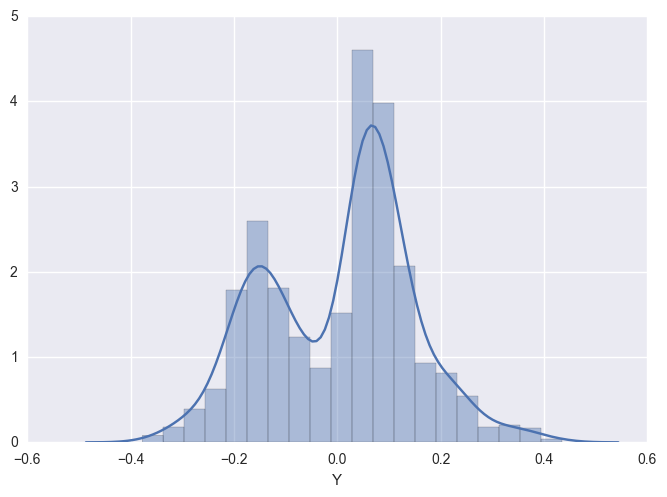

432
47
186
258
291


In [68]:

#Plot the growth distribution

sns.distplot(zip_aggregated_3['Y'].dropna())
plt.show()


#Absolute number of businesses in the corresponding intervals of growth

print(sum(zip_aggregated_3['Y']<-0.05))
print(sum((zip_aggregated_3['Y']>=-0.05)&(zip_aggregated_3['Y']<0)))
print(sum((zip_aggregated_3['Y']>=0)&(zip_aggregated_3['Y']<0.05)))
print(sum((zip_aggregated_3['Y']>=0.05)&(zip_aggregated_3['Y']<0.10)))
print(sum((zip_aggregated_3['Y']>=0.1)))


In [69]:
zip_aggregated_3.columns

Index(['postal_code', 'Years', 'useful_mean', 'useful_std', 'useful_median',
       'funny_mean', 'funny_std', 'funny_median', 'cool_mean', 'cool_std',
       'cool_median', 'Price_mean', 'Price_std', 'Price_median',
       'stars_1_mean', 'stars_1_std', 'stars_1_median', 'stars_2_mean',
       'stars_2_std', 'stars_2_median', 'stars_3_mean', 'stars_3_std',
       'stars_3_median', 'stars_4_mean', 'stars_4_std', 'stars_4_median',
       'stars_5_mean', 'stars_5_std', 'stars_5_median', 'stars_mean',
       'stars_std', 'stars_median', 'No_business', 'reviews_perc',
       'useful_mean_change', 'useful_std_change', 'useful_median_change',
       'funny_mean_change', 'funny_std_change', 'funny_median_change',
       'cool_mean_change', 'cool_std_change', 'cool_median_change',
       'Price_mean_change', 'Price_std_change', 'Price_median_change',
       'stars_1_mean_change', 'stars_1_std_change', 'stars_1_median_change',
       'stars_2_mean_change', 'stars_2_std_change', 'stars_2_median_

In [70]:
# Select columns that we need:

zip_aggregated_final = zip_aggregated_3[['postal_code','Years','useful_mean','funny_mean','cool_mean','Price_mean','useful_mean_change','funny_mean_change',\
                                    'cool_mean_change','Price_mean_change','useful_median','funny_median','cool_median','Price_median',\
                                    'useful_std','funny_std','cool_std','Price_std','stars_1_mean','stars_2_mean','stars_3_mean','stars_4_mean',\
                                    'stars_5_mean','stars_1_mean_change','stars_2_mean_change','stars_3_mean_change','stars_4_mean_change','stars_5_mean_change',\
                                    'stars_mean','stars_median','stars_std','reviews_perc','prev_stars','stars_mean_change','NumBsqft_Rev',\
                                    'Bsqft_change','Y','MedPrice_sqft','MedPrice_sqft_tminus1',\
                                    'MedPrice_sqft_tminus2','MedPrice_sqft_tplus1','Area','No_business']]

In [71]:
zip_aggregated_final.head()

,postal_code,Years,useful_mean,funny_mean,cool_mean,Price_mean,useful_mean_change,funny_mean_change,cool_mean_change,Price_mean_change,...,stars_mean_change,NumBsqft_Rev,Bsqft_change,Y,MedPrice_sqft,MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Area,No_business
0,85003,2006,1.681818,1.045455,1.409091,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.102107,0.000000,0.013834,253.0,215.5,156.5,256.5,1.85137,15.0
1,85003,2007,2.945312,1.843750,2.656250,1.842105,0.751267,0.763587,0.885081,-0.078947,...,0.080357,23.766179,1.933333,-0.136452,256.5,253.0,215.5,221.5,1.85137,44.0
2,85003,2008,3.200000,2.237778,2.635556,1.793651,0.086472,0.213710,-0.007791,-0.026304,...,-0.039118,38.890112,0.636364,-0.115124,221.5,256.5,253.0,196.0,1.85137,72.0
3,85003,2009,2.694719,1.735974,2.150165,1.824324,-0.157900,-0.224242,-0.184170,0.017101,...,0.022800,43.751376,0.125000,-0.216837,196.0,221.5,256.5,153.5,1.85137,81.0
4,85003,2010,1.560914,0.784264,0.977157,1.815217,-0.420751,-0.548228,-0.545543,-0.004992,...,0.045301,55.634465,0.271605,-0.065147,153.5,196.0,221.5,143.5,1.85137,103.0


In [74]:
#save to pickle ------- Checkpoint
import pickle
output_file = open("Feature_Matrix_Final.dat","wb")
pickle.dump(zip_aggregated_final, output_file)
output_file.close()

In [76]:
#export to CSV
zip_aggregated_final.to_csv("Feature_Matrix_Final.csv")

In [80]:
zip_aggregated_final.dropna()

,postal_code,Years,useful_mean,funny_mean,cool_mean,Price_mean,useful_mean_change,funny_mean_change,cool_mean_change,Price_mean_change,...,stars_mean_change,NumBsqft_Rev,Bsqft_change,Y,MedPrice_sqft,MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Area,No_business
1,85003,2007,2.945312,1.843750,2.656250,1.842105,0.751267,0.763587,0.885081,-0.078947,...,0.080357,23.766179,1.933333,-0.136452,256.5,253.0,215.5,221.5,1.851370,44.0
2,85003,2008,3.200000,2.237778,2.635556,1.793651,0.086472,0.213710,-0.007791,-0.026304,...,-0.039118,38.890112,0.636364,-0.115124,221.5,256.5,253.0,196.0,1.851370,72.0
3,85003,2009,2.694719,1.735974,2.150165,1.824324,-0.157900,-0.224242,-0.184170,0.017101,...,0.022800,43.751376,0.125000,-0.216837,196.0,221.5,256.5,153.5,1.851370,81.0
4,85003,2010,1.560914,0.784264,0.977157,1.815217,-0.420751,-0.548228,-0.545543,-0.004992,...,0.045301,55.634465,0.271605,-0.065147,153.5,196.0,221.5,143.5,1.851370,103.0
5,85003,2011,1.506351,0.625741,0.766300,1.728000,-0.034956,-0.202130,-0.215787,-0.048048,...,-0.029343,75.619662,0.359223,0.108014,143.5,153.5,196.0,159.0,1.851370,140.0
6,85003,2012,1.340246,0.582181,0.653610,1.755102,-0.110270,-0.069613,-0.147057,0.015684,...,0.005859,89.663313,0.185714,0.150943,159.0,143.5,153.5,183.0,1.851370,166.0
7,85003,2013,1.222102,0.497574,0.619407,1.769634,-0.088151,-0.145328,-0.052329,0.008280,...,-0.003173,114.509774,0.277108,0.103825,183.0,159.0,143.5,202.0,1.851370,212.0
8,85003,2014,0.983722,0.381428,0.429893,1.769231,-0.195058,-0.233425,-0.305961,-0.000228,...,0.033179,128.553425,0.122642,0.064356,202.0,183.0,159.0,215.0,1.851370,238.0
9,85003,2015,0.953163,0.362835,0.465937,1.785714,-0.031064,-0.048747,0.083844,0.009317,...,0.012222,143.677357,0.117647,0.055814,215.0,202.0,183.0,227.0,1.851370,266.0
10,85003,2016,0.787174,0.321199,0.460655,1.744292,-0.174145,-0.114752,-0.011335,-0.023196,...,-0.019259,134.494970,-0.063910,0.035242,227.0,215.0,202.0,235.0,1.851370,249.0
